<a href="https://colab.research.google.com/github/AvonleaFisher/Analyzing-NYC-311-Service-Requests/blob/main/Exploring_the_Data/Correlation_Heatmap_and_Wordcloud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this section, we'll create summaries and visualizations to explore the data.

**Note:** Notebooks with exploratory visualizations have been broken up into multiple sections to reduce file size. Dependencies required across all EDA notebooks are imported below. To view animated plots that do not render on GitHub, enter the URL into [Jupyter Notebook Viewer](https://nbviewer.jupyter.org/).

# Loading Dependencies

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import string

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.collocations import *
from nltk import FreqDist
from nltk.probability import FreqDist
from os import path
from PIL import Image
import matplotlib.pyplot as plt
import os
from wordcloud import WordCloud, STOPWORDS

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import random
import plotly.io as pio

 #display plotly figures
pio.renderers.default = "plotly_mimetype+notebook_connected"

# Importing the Data

The data used in this notebook can be accessed via the following sharable Google Drive link:

[community_board_311.csv](https://drive.google.com/file/d/1sWrkeaPOhpn37nxT9_zk2vs009nZOrlB/view?usp=sharing)

In [3]:
from google.colab import drive
drive.mount("/content/drive")
path = '/content/drive/MyDrive/Colab Notebooks/community_board_311.csv' #change path to your Google Drive file location
df = pd.read_csv(path, index_col=0)

Mounted at /content/drive


/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



## Correlation Heatmap

The scatterplots created in the previous EDA notebook only show whether there is a relationship between average daily calls and other variables. A correlation heatmap, conversely, can highlight possible relationships between all variables in the dataset. To include agency in the heatmap, we'll dummy-encode the agency values. 

In [4]:
dummy_agency = pd.get_dummies(df.agency)
dummy_agency.drop('DOITT', axis=1, inplace=True)

In [5]:
df_with_dummy_agency = pd.concat([df, dummy_agency], axis=1)

In [6]:
df_with_dummy_agency.head()

,created_date,complaint_type,agency,community_board,latitude,longitude,descriptor,borough,day,month,day_of_week,hour,area_sqmi,count_hosp_clinic,count_libraries,count_parks,count_public_schools,crime_per_1000,female_15_19,female_20_24,female_25_29,female_30_34,female_35_39,female_40_44,female_45_49,female_50_54,female_55_59,female_60_64,male_10_14,male_15_19,male_20_24,male_25_29,male_30_34,male_35_39,male_40_44,male_45_49,male_50_54,male_55_59,male_60_64,under18_rate,over65_rate,lots_total,lots_vacant,pct_white_nh,pct_black_nh,pct_asian_nh,pct_other_nh,pct_hispanic,mean_commute,pop_change_00_10,pct_clean_strts,unemployment,poverty_rate,lep_rate_boro,pct_hh_rent_burd,DCA,DEP,DOB,DOE,DOHMH,DOT,DPR,DSNY,EDC,HPD,NYPD,OSE,TLC
0,2020-06-01 07:28:32,Covid-19 Non-Essential Construction,DOB,8 BRONX,40.879340,-73.920625,construction,BRONX,2020-06-01,6,0,7,3.3,10,5,6,19,8.8,2.2,3.3,3.8,3.9,3.5,3.0,3.4,3.2,3.3,3.4,2.7,2.7,3.3,3.8,3.5,2.9,2.9,2.9,2.6,2.8,2.2,21.1,19.0,4998,431,32.3,12.0,4.4,2.5,48.8,46.2,0.0,96.9,5.0,15.8,25.8,46.6,0,0,1,0,0,0,0,0,0,0,0,0,0
1,2020-06-01 07:39:46,Noise - Vehicle,NYPD,8 BRONX,40.890298,-73.907978,engine idling,BRONX,2020-06-01,6,0,7,3.3,10,5,6,19,8.8,2.2,3.3,3.8,3.9,3.5,3.0,3.4,3.2,3.3,3.4,2.7,2.7,3.3,3.8,3.5,2.9,2.9,2.9,2.6,2.8,2.2,21.1,19.0,4998,431,32.3,12.0,4.4,2.5,48.8,46.2,0.0,96.9,5.0,15.8,25.8,46.6,0,0,0,0,0,0,0,0,0,0,1,0,0
2,2020-06-01 07:57:46,Street Condition,DOT,8 BRONX,40.885368,-73.907276,pothole,BRONX,2020-06-01,6,0,7,3.3,10,5,6,19,8.8,2.2,3.3,3.8,3.9,3.5,3.0,3.4,3.2,3.3,3.4,2.7,2.7,3.3,3.8,3.5,2.9,2.9,2.9,2.6,2.8,2.2,21.1,19.0,4998,431,32.3,12.0,4.4,2.5,48.8,46.2,0.0,96.9,5.0,15.8,25.8,46.6,0,0,0,0,0,1,0,0,0,0,0,0,0
3,2020-06-01 07:58:16,Street Condition,DOT,8 BRONX,40.885269,-73.907309,pothole,BRONX,2020-06-01,6,0,7,3.3,10,5,6,19,8.8,2.2,3.3,3.8,3.9,3.5,3.0,3.4,3.2,3.3,3.4,2.7,2.7,3.3,3.8,3.5,2.9,2.9,2.9,2.6,2.8,2.2,21.1,19.0,4998,431,32.3,12.0,4.4,2.5,48.8,46.2,0.0,96.9,5.0,15.8,25.8,46.6,0,0,0,0,0,1,0,0,0,0,0,0,0
4,2020-06-01 08:05:43,Broken Parking Meter,DOT,8 BRONX,40.886087,-73.909832,graffiti,BRONX,2020-06-01,6,0,8,3.3,10,5,6,19,8.8,2.2,3.3,3.8,3.9,3.5,3.0,3.4,3.2,3.3,3.4,2.7,2.7,3.3,3.8,3.5,2.9,2.9,2.9,2.6,2.8,2.2,21.1,19.0,4998,431,32.3,12.0,4.4,2.5,48.8,46.2,0.0,96.9,5.0,15.8,25.8,46.6,0,0,0,0,0,1,0,0,0,0,0,0,0


Text(0.5, 1.0, 'Correlation Heatmap')

findfont: Font family ['silom'] not found. Falling back to DejaVu Sans.


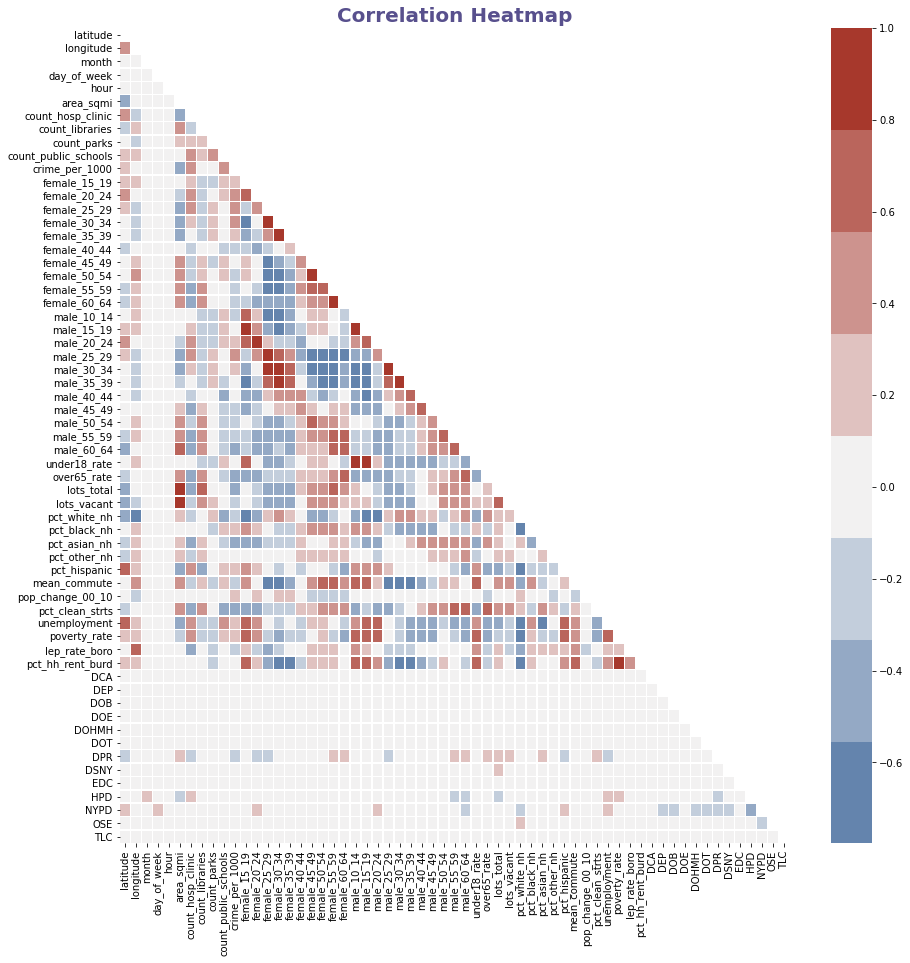

In [7]:
mask = np.zeros_like(df_with_dummy_agency.corr(), dtype=bool)


mask[np.triu_indices_from(mask)] = True


fig, ax = plt.subplots(figsize=(15,15))

cmap = sns.diverging_palette(250, 15, s=75, l=40, n=9)

sns.heatmap(df_with_dummy_agency.corr(),mask=mask,cmap=cmap,
            vmax=1,center=0, 
            linewidth=.5)

font_dict = {'fontsize': 20, 'family': 'silom', 
             'color': '#58508d', 'weight': 'bold'}

# ax.set_title('Correlation Heatmap', fontdict=font_dict)

plt.title('Correlation Heatmap', fontdict=font_dict)

None of the numeric variables appear to be strongly correlated with any agency category in either direction. All dark red (positive) or dark blue (negative) cells are at the intersection of the numeric varisbles themselves. Below, we create a dataframe to display which features have a correlation whose absolute value is at least .85.

In [8]:
Multicollinear_Features = []
Multicollinear_Corr = []

def check_multicollinearity(feature):
    for var, correlation in corr[feature].T.iteritems():
        if abs(correlation) >= .85 and var != feature:
            Multicollinear_Features.append([feature, var])
            Multicollinear_Corr.append(correlation)

corr = df_with_dummy_agency.corr()

for feature in corr:
    check_multicollinearity(feature)
    
MC_df = pd.DataFrame({'Correlations':Multicollinear_Corr, 
                      'Features': Multicollinear_Features}).sort_values(
                          by=['Correlations'], ascending=False)
MC_df

,Correlations,Features
5,0.942755,"[male_10_14, under18_rate]"
11,0.942755,"[under18_rate, male_10_14]"
2,0.896719,"[female_15_19, male_15_19]"
6,0.896719,"[male_15_19, female_15_19]"
9,0.891989,"[male_30_34, male_35_39]"
10,0.891989,"[male_35_39, male_30_34]"
1,0.891457,"[area_sqmi, lots_vacant]"
13,0.891457,"[lots_vacant, area_sqmi]"
0,0.875427,"[area_sqmi, lots_total]"
12,0.875427,"[lots_total, area_sqmi]"


Unsurprisingly, many of population variables with similar age ranges are highly correlated, as are the lot counts with the districts' square milage. We'll drop one variable in each of the multicollinear pairings above from the data.

In [9]:
df.drop(['male_10_14', 'female_15_19', 'male_35_39', 'male_25_29', 'area_sqmi'], axis=1, inplace=True)

## Descriptor Wordcloud

Using text from the descriptor column, we'll create a word cloud to visualize the most common words that appear in the calls' descriptions. First, the below function will clean the descriptor data and return a list of words found in the column (excluding stopwords).

In [10]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

def clean_words(text):
    
    """Takes in a string or iterable of strings, and returns a cleaned list 
       of words in the text that was passed in."""
    
    #join all strings in text and separate them by white space
    joined_text = " ".join(text) 
    
    #remove all characters that are not letters
    joined_text = re.sub('[^A-Za-z ]+', ' ', joined_text)
    
    #convert all words in list to their base form, or 'lemma'
    words = [WordNetLemmatizer().lemmatize(word) for word in joined_text]
    
    #create a list of individual strings for each word in the text 
    words = word_tokenize(joined_text)
    
    
    clean_words_list = []
    
    for word in words:
        
        #exclude words that don't contribute to the meaning of the text
        stopwords_list = stopwords.words('english')
        for w in ['http', 'com', 'amp', 'www']:
            stopwords_list.append(w)
        
        if len(word) > 2 and word not in stopwords_list:
            
            #populate clean words list with remaining words
            clean_words_list.append(word.lower())
    
    return clean_words_list

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
#run the function on the descriptor column
clean_descriptor = clean_words(df.descriptor)

The mask below, accessed via Vector Stock, allows the wordcloud to appear in the shape of New York City. For different mask options, a different set of max words and font sizes than the set used below may be optimal. 

In [12]:
#Image Attribution: Designed by vectorstock (Image #19210492 at VectorStock.com)
mask = np.array(Image.open("/content/drive/MyDrive/Colab Notebooks/vectorstock_19210492.png"))

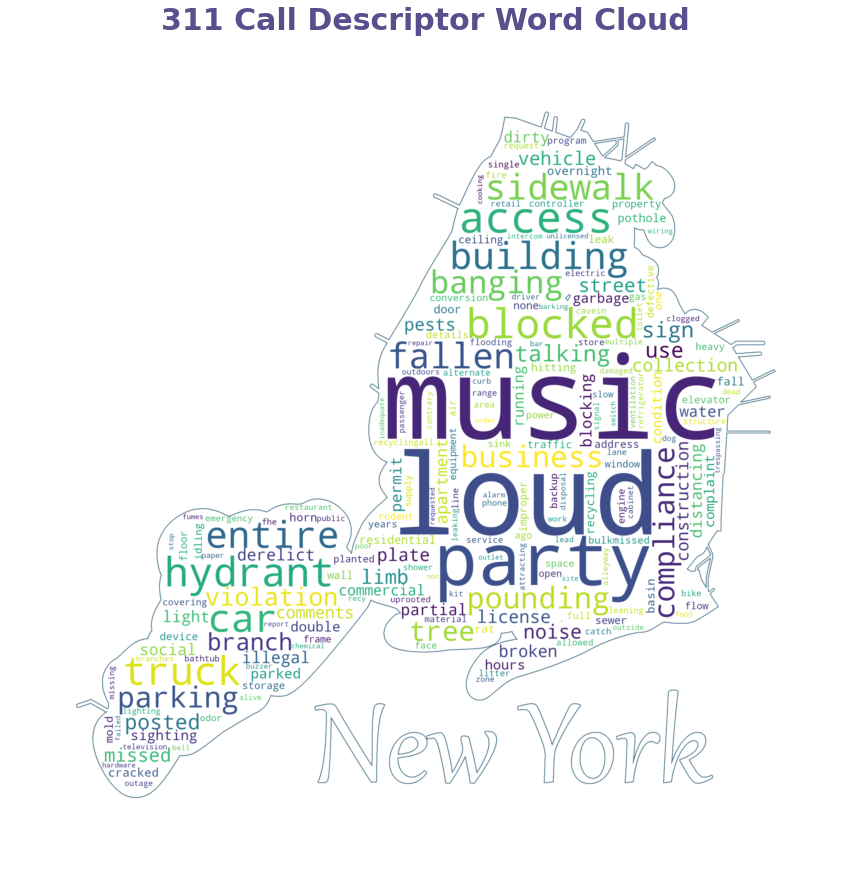

In [20]:
wc = WordCloud(background_color="white", mask=mask, max_words=200, 
               max_font_size =500, collocations=False,
               contour_width=2, contour_color='#51788c')

clean_string = '.'.join(clean_descriptor)
wc.generate(clean_string)

f = plt.figure(figsize=(15,17))
plt.axis("off")
plt.imshow(wc, interpolation='bilinear')

font_dict = {'fontsize': 30, 'color': '#58508d', 'weight': 'bold'}

plt.title('311 Call Descriptor Word Cloud', fontdict=font_dict)
plt.axis("off")
plt.show()

The words "music," "party," and "loud" are clearly the largest. This is expected, given that noise complaints comprise the most common complaint categories. This wordcloud gives us an easily interpretable visual sense of how the frequency of certain complaint descriptions compare to others.  

# References

[Seaborn Heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html)

[Masked Wordcloud](https://amueller.github.io/word_cloud/auto_examples/masked.html)